shape of binary warped (720, 1280)
shape of binary warped (720, 1280)
shape of binary warped (720, 1280)
shape of binary warped (720, 1280)
shape of binary warped (720, 1280)
shape of binary warped (720, 1280)
shape of binary warped (720, 1280)
shape of binary warped (720, 1280)


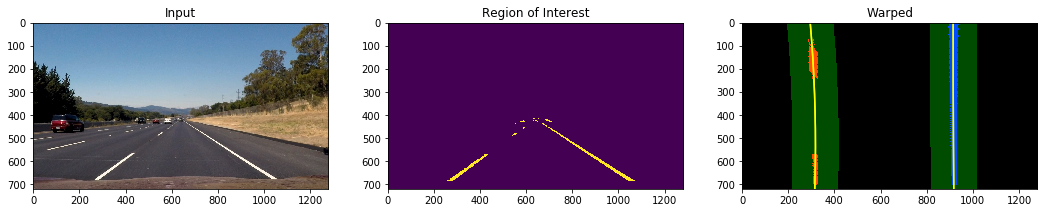

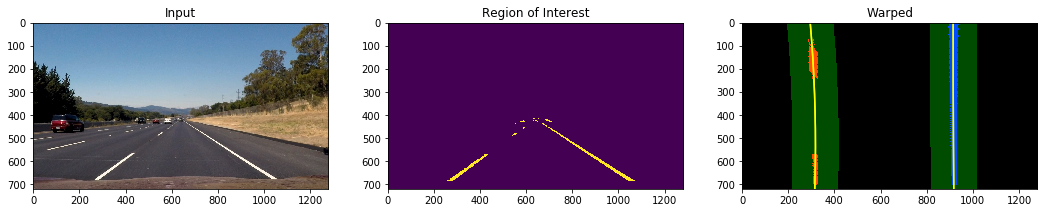

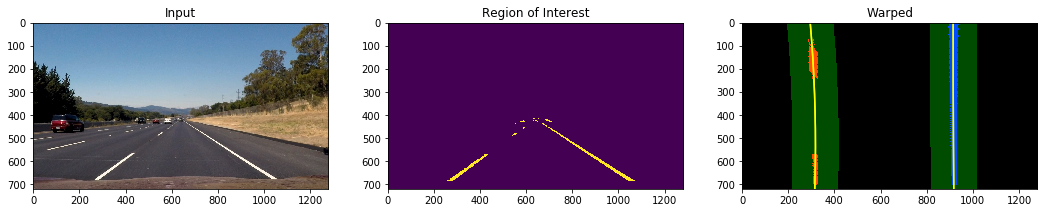

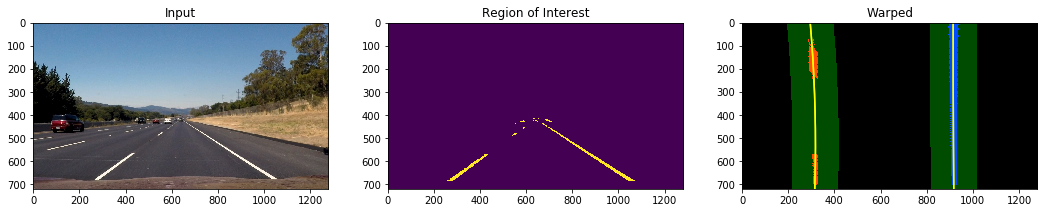

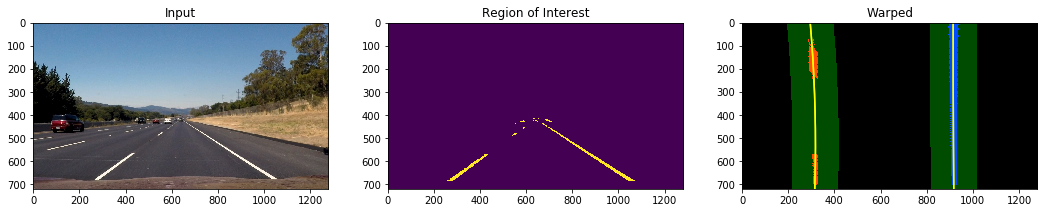

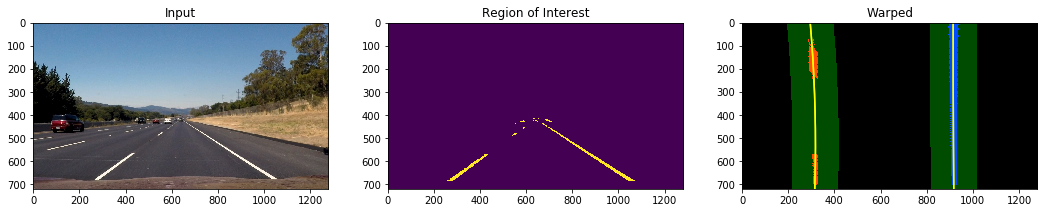

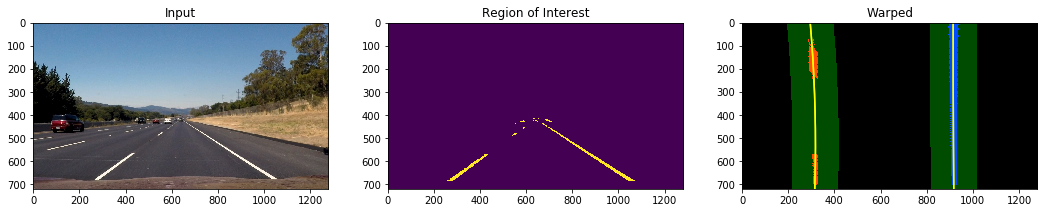

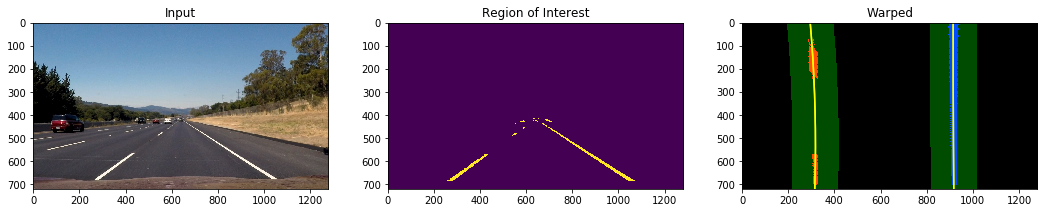

In [5]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import pickle
%matplotlib inline

#Loading pickle
def load_pickle():
    dist_pickle = pickle.load( open('data/calibration_pickle.p', 'rb'))
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    return mtx, dist

#Perspective Transformation
def warp_image(img, src, dst):
    #Perspective tranform, M
    M = cv2.getPerspectiveTransform(src, dst)

    #Inverse Perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    img_size = (img.shape[1], img.shape[0])
    #warped image - uses linear interpolation
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped_img

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Determine sobel for x or y
    Absolute soble
    uint8
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        #print('inside x')
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
        abs_sobel = np.absolute(sobel)
    else:
        #print('inside y')
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        abs_sobel = np.absolute(sobel)
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    img_binary = np.zeros_like(scaled_sobel)
    img_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return img_binary



def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Determine sobelx and sobely
    sqrt(x**2 + y**2)
    uint8
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)

    #scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    scale_factor = np.max(sobel_mag)*255
    scaled_sobel = (sobel_mag/scale_factor).astype(np.uint8)
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, thresh, sobel_kernel=3):
    """
    Determine sobelx and sobely
    Absolute
    arctan2(y, x)
    binary
    """
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir_sobel = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    return dir_binary

def color_threshold(img, sthresh=(0, 255), vthresh=(0, 255)):
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = img_hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = img_hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return output

######################################################################################
#Undistorting
mtx, dist = load_pickle()
test_images = glob.glob('test_images/*.jpg')
#print('No of Images read {}'.format(len(test_images)))
for idx, image_name in enumerate(test_images):
#    img = cv2.imread(image_name)
    img = cv2.imread('test_images/straight_lines2.jpg')
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

    #Plotting Undistorted Image
    #     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    #     ax1.set_title('Distorted / Original Image')
    #     ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #     ax2.set_title('Undistorted Image')
    #     ax2.imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))

    #Thresholding
    sobelx = abs_sobel_thresh(undistorted_img, 'x', 3, (30,125))
    sobely = abs_sobel_thresh(undistorted_img, 'y', 3, (70,255))
    dir_binary = dir_threshold(undistorted_img, (0.8, 1.2))
    sv_channel = color_threshold(undistorted_img, (100, 255), (90, 255))

    combined_binary = np.zeros_like(sobelx)
    combined_binary[((sobelx == 1 )  & (sobely == 1 ) & (dir_binary == 1)  | (sv_channel == 1))] = 1

    #print('Shapes Sobel {} S Channel {} Combined Binary {}'.format(sobelx.shape, sv_channel.shape, combined_binary.shape))


    #Region of Interest
    height, width = img.shape[:2]
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #print('height {} width {} ignore maks color {}'.format(height, width, ignore_mask_color))

    vertices = np.array([[(0, 0.95*height),(0.49*width,0.56*height),
                          (0.51*width,0.56*height),(width, 0.95*height)]], dtype=np.int32)
    mask = np.zeros_like(combined_binary)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    roi_image = cv2.bitwise_and(combined_binary, mask)

    #Perspective Transformation
    src = np.float32([[220,720],
                      [1110, 720],
                      [570, 470],
                      [722, 470]])
    dst = np.float32([[320,720],
                      [920, 720],
                      [320, 1],
                      [920, 1]])
    warped_img = warp_image(roi_image, src, dst)

    #     write_name_masked = image_name.split('.', 1)[0]+'_masked.jpg'
    #     write_name_warped = image_name.split('.', 1)[0]+'_warped.jpg'
    #     print(write_name_masked)
    #     cv2.imwrite(write_name_masked, roi_image)
    #     cv2.imwrite(write_name_warped, warped_img)

    #Plotting
    fig, axs = plt.subplots(1,3, figsize=(18, 18))
    axs[0].set_title('Input')
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Region of Interest')
    axs[1].imshow(roi_image)
    axs[2].set_title('Warped')
    axs[2].imshow(warped_img)

    #REMOVE this
    binary_warped = warped_img
    ########################################################################
    #Lane Detection Start
    print('shape of binary warped', binary_warped.shape)

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)